# This Notebook

Visualizes elements of a particular box and generate statistical statements

In [1]:
datapath = '/freya/ptmp/mpa/wuze/data/2406046_das23'

%matplotlib widget
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pickle


import sys
import os
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/codes'))
from jason import plotting_def, plot_prettier

plotting_def()

# Functions

In [2]:
import h5py

In [3]:
def plot_data_tab(fname=f'{datapath}/1d_sod_tube/Sod.block0.out1.00025.tab', x='x1v', y='rho'):
    """
    a function to plot 1d data from .tab files
    """
    data = np.loadtxt(fname).T
    keys = list('i x1v rho press vel1 vel2 vel3'.split())
    dataf = {keys[i]: data[i] for i in range(len(keys))}
    
    plt.plot(dataf[x], dataf[y])
    plt.xlabel(x); plt.ylabel(y)
    plt.show()

In [4]:
import sys
import os
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena_pp/vis/python'))
from athena_read import athdf

In [5]:
def get_datamd(fname=f'{datapath}/cloud/Turb.out2.00101.athdf',
               key='rho', verbose=False):
    """
    Get and plot data for 2d/3d runs
    """
    data = athdf(filename=fname,)
    if verbose: print(list(data.keys()))
    try:
        len(data[key])
        return data[key][0] if len(data[key]) == 1 else data[key]
    except:
        return data[key]
    

def plot_data2d(fname=f'{datapath}/cloud/Turb.out2.00101.athdf',
                key='rho'):
    plt.imshow(get_datamd(key=key, verbose=False), interpolation='none')
    plt.colorbar()
    plt.title(key)
    plt.show()

In [6]:
_ = get_datamd(verbose=True)

['Coordinates', 'DatasetNames', 'MaxLevel', 'MeshBlockSize', 'NumCycles', 'NumMeshBlocks', 'NumVariables', 'RootGridSize', 'RootGridX1', 'RootGridX2', 'RootGridX3', 'Time', 'VariableNames', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3']


# Turbulence simulations

## Kinetic Energy

['time', 'dt', 'mass', '1-mom', '2-mom', '3-mom', '1-KE', '2-KE', '3-KE', 'tot-E', '0-scalar', 'rho_sum', 'rho_sq_sum', 'c_s_sum', 'cold_gas', 'warm_gas', 'total_cooling', 'T_sum']


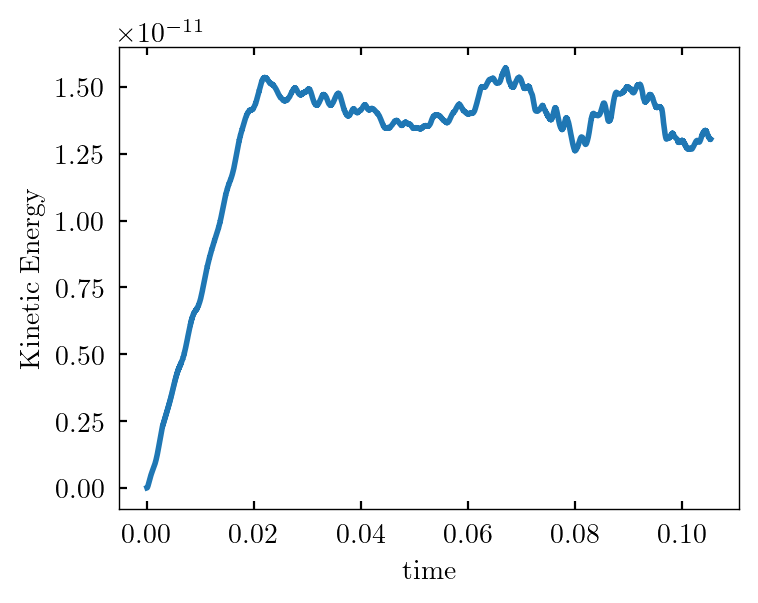

In [7]:
datapath = '/freya/ptmp/mpa/wuze/data/240606_das23'
fname = f'{datapath}/turb/Turb.hst'

with open(fname, 'r') as file: keys_raw = file.readlines()[1]
keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
data = np.loadtxt(fname).T
dataf = {keys[i]: data[i] for i in range(len(keys))}
print(keys)

time = dataf['time']
e_k = dataf['1-KE'] + dataf['2-KE'] + dataf['3-KE']

# plot the time evolution
plt.subplots(figsize=(4, 3))
plt.plot(time, e_k)
plt.xlabel('time'); plt.ylabel('Kinetic Energy')
plt.show()

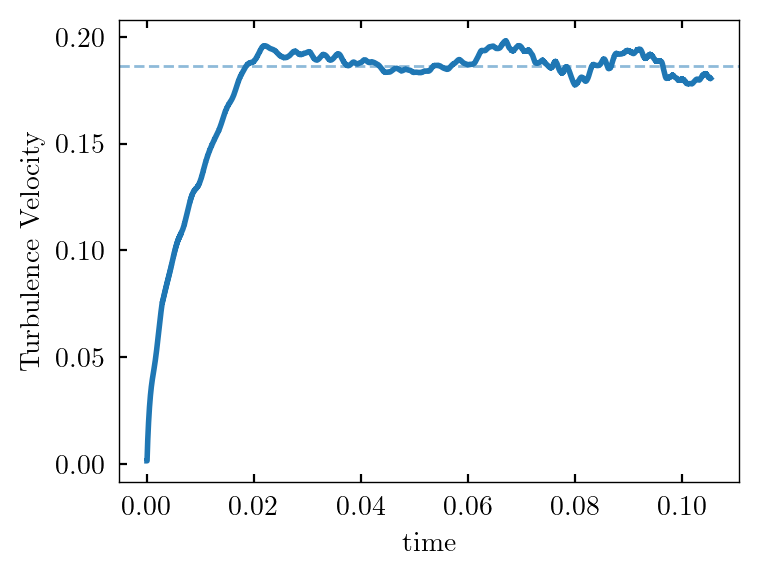

In [16]:
v_turb = np.sqrt(2 * e_k / dataf['mass'])
plt.subplots(figsize=(4, 3))
plt.plot(time, v_turb)
plt.axhline(0.1865317171670572, alpha=0.5, lw=1, ls='--')
plt.xlabel('time'); plt.ylabel('Turbulence Velocity')
plt.show()

## Pressure

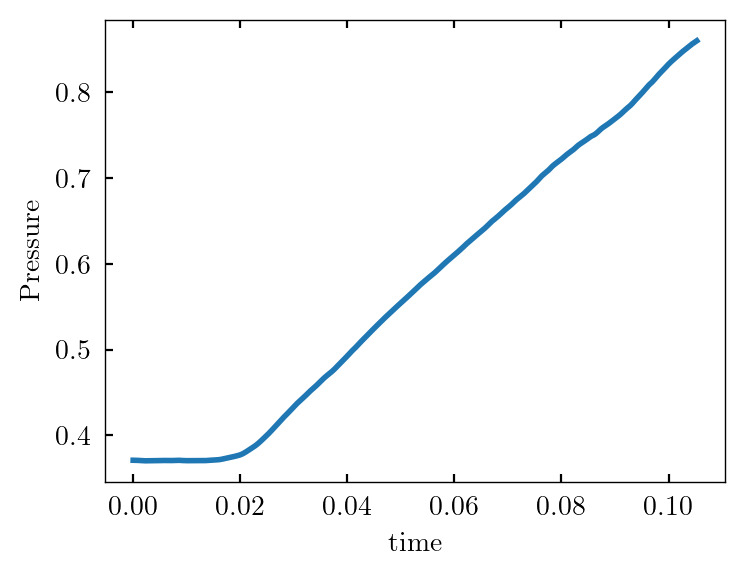

In [11]:
pressure = (dataf['T_sum'] / 64**3) * (dataf['rho_sum'] / 64**3) / (u.KELVIN * u.mu)
plt.subplots(figsize=(4, 3))
plt.plot(time, pressure)
plt.xlabel('time'); plt.ylabel('Pressure')
plt.show()

# in later stages of eddie driving, the temperature & pressure increases

# Calculate Mach number

## Units

In [10]:
"""Define constants"""

class unit():
    def __init__(self):        
        # length, time, and mass constants
        self.CONST_pc  = 3.086e18
        self.CONST_yr  = 3.154e7
        self.CONST_amu = 1.66053886e-24
        self.CONST_kB  = 1.3806505e-16
        self.unit_length = self.CONST_pc*1e3  # 1 kpc
        self.unit_time   = self.CONST_yr*1e6  # 1 Myr
        self.unit_density = self.CONST_amu    # 1 mp/cm-3
        self.unit_velocity = self.unit_length/self.unit_time
        self.KELVIN = self.unit_velocity*self.unit_velocity*self.CONST_amu/self.CONST_kB
        self.unit_q = (self.unit_density * (self.unit_velocity**3))/self.unit_length
        self.g = 5/3
        
        # avg atomic mass
        Xsol = 1.0
        Zsol = 1.0
        
        X = Xsol * 0.7381
        Z = Zsol * 0.0134
        Y = 1 - X - Z
        
        self.mu  = 1.0/(2.*X+ 3.*(1.-X-Z)/4.+ Z/2.);
        self.mue = 2.0/(1.0+X);
        self.muH = 1.0/X;
        self.mH = 1.0

        # alpha values for different sims
        self.alpha_hyd = 2 ** (1 / 3)  # 1.26 # 1.383
        self.alpha_mhd = (2 * 4.2 / 0.77) ** (1 / 3)

u = unit()
u.mu

0.5990624672387714

In [12]:
def calc_T(P, rho):
    """
    Calculates temeprature from constants
    ----------
    P: gas pressure
    rho: gas density
    """
    T = P/rho * u.KELVIN * u.mu
    return T

def calc_cs(T):
    """
    Calculates sound speed
    ----------
    T: temperature
    mu: avg atomic number of the gas
    """
    # convert to cm
    m_to_cm = 100

    # return np.sqrt(g.g*R*T_hot/M) * m_to_cm/g.unit_velocity
    # return np.sqrt(u.g * u.CONST_kB / (u.mu * u.CONST_amu) * T) * m_to_cm / u.unit_velocity
    return np.sqrt(u.g * u.CONST_kB / (u.mu * u.CONST_amu) * T) / u.unit_velocity

def calc_mach(v_turb, P, rho):
    """
    Calculates the Mach number
    ----------
    v_turb: turbulence velocity
    P, rho
    """
    T = calc_T(P, rho)
    cs = calc_cs(T)
    print(f'cs = {cs}')
    return v_turb / cs

def calc_dedt_mach(mach, P, rho, L):
    """
    Returns required dedt for a given Mach number, density, temperature, and box size
    """
    # calculate sound speed first
    T = calc_T(P, rho)
    cs_new = calc_cs(T)
    print(f"cs_hot: {cs_new}")

    dedt_req = rho * (cs_new**3) * (L**2) * (mach**3) / (u.alpha_hyd**3)
    return dedt_req


def calc_dedt_vturb(v_turb, rho, L):
    """
    Returns required dedt for a given turbulent velocity, density, and box size

    Does NOT calculate sound speed, so no pressure required
    """
    
    dedt_req = rho * v_turb**3 * (L**2) / (u.alpha_hyd**3)
    return dedt_req

def find_ind_l(seq, val):
    seq = list(seq)
    return seq.index(list(filter(lambda x: x>val, seq))[0])

## t_eddie

In [19]:
# filter for v_turb after stabalizes
v_turb_stb = v_turb[find_ind_l(time, 0.02):]

# calculate t_eddie
t_eddie = 1/np.mean(v_turb_stb)
# approximate t_corr
t_corr = t_eddie
print(t_corr)

# apprximate dtdrive = 0.01 * t_eddie
dtdrive = 0.01 * t_eddie
print(dtdrive)

5.316040827064125
0.05316040827064125


## Predict dedt

In [13]:
# calculate debt needed to achieve 0.5 mach
v_turb_end = 0.2
rho = 1
calc_dedt_mach(v_turb_end,
               rho=rho,
               L=1)  # box size = x1max - x1min

0.004000000000000001

In [14]:
_ = get_datamd(fname=f'{datapath}/turb/Turb.out2.00100.athdf', verbose=True, key='press')

['Coordinates', 'DatasetNames', 'MaxLevel', 'MeshBlockSize', 'NumCycles', 'NumMeshBlocks', 'NumVariables', 'RootGridSize', 'RootGridX1', 'RootGridX2', 'RootGridX3', 'Time', 'VariableNames', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3']


## Turbulence

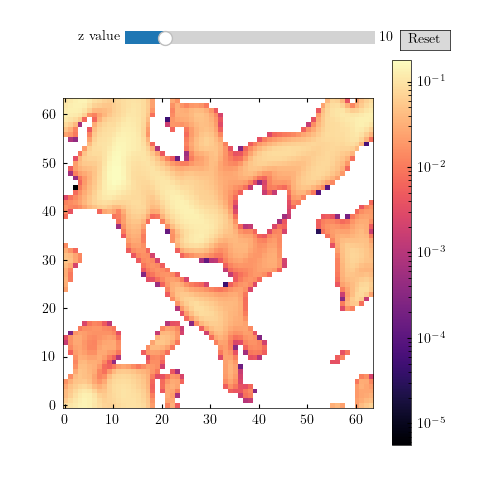

In [15]:
# def visualize_3d(fname=f'{datapath}/turb_240528/Turb.out3.00004.athdf', verbose=True, key='dens'):
fname=f'{datapath}/cloud/Turb.out2.00110.athdf'; verbose=False
%matplotlib widget
from matplotlib.widgets import Button, Slider

z_range = [0, 63]
z_init = 10
vel_comp = [get_datamd(fname=fname, verbose=verbose, key='vel1')]
            # ,
            # get_datamd(fname=fname, verbose=verbose, key='vel2'),
            # get_datamd(fname=fname, verbose=verbose, key='vel3')]
vel_comp = np.array(vel_comp)

vel = np.swapaxes(vel_comp, 0, 3)
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
img = plt.imshow(vel[z_init], interpolation='none', norm='log')
# plt.title('Density')
plt.colorbar()

plt.ioff()

# Make a horizontal slider to control the z slice
ax_slider = fig.add_axes([0.25, 0.90, 0.5, 0.05])
redshift_slider = Slider(
    ax=ax_slider,
    label=r'z value',
    valmin=z_range[0],
    valmax=z_range[1],
    valinit=z_init,
    valstep=1.
)

# The function to be called anytime a slider's value changes
def update(z):
    # update to redshift
    img.set_data(vel[int(z)])
    fig.canvas.draw_idle()
redshift_slider.on_changed(update)  # register the update function with each slider

# Create a button to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.9, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')
def reset(event):
    redshift_slider.reset()
button.on_clicked(reset)
plt.show()
%matplotlib inline
plotting_def()

## Mach number

In [16]:
plotting_def()

['time', 'dt', 'mass', '1-mom', '2-mom', '3-mom', '1-KE', '2-KE', '3-KE', 'tot-E', 'rho_sum', 'rho_sq_sum', 'c_s_sum', 'cold_gas', 'total_cooling', 'T_sum']


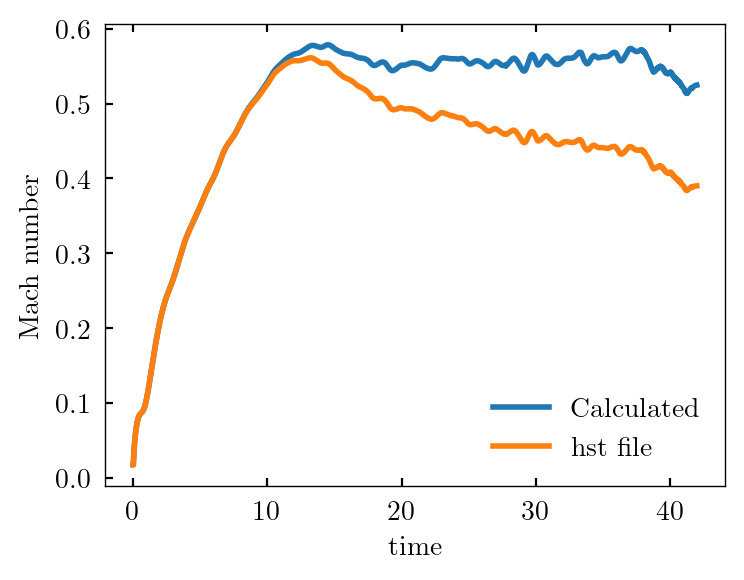

In [17]:
fname = f'{datapath}/turb/Turb.hst'

# calculate v_turb
with open(fname, 'r') as file: keys_raw = file.readlines()[1]
keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
data = np.loadtxt(fname).T
dataf = {keys[i]: data[i] for i in range(len(keys))}
print(keys)
time = dataf['time']
e_k = dataf['1-KE'] + dataf['2-KE'] + dataf['3-KE']
v_turb = np.sqrt(2 * e_k / dataf['mass'])

# calculate mach number
fname=f'{datapath}/turb/Turb.out2.00100.athdf'
rho = get_datamd(fname=fname, verbose=False, key='rho')
press = get_datamd(fname=fname, verbose=False, key='press')
T_scale = 4000000
mach = v_turb / calc_cs(T_scale)

# mach number from the turb.hst file
mach_sim = v_turb / dataf['c_s_sum'] * 64**3

plt.subplots(figsize=(4, 3))
plt.plot(time, mach, label='Calculated')
plt.plot(time, mach_sim, label='hst file')
plt.xlabel('time'); plt.ylabel('Mach number')
plt.legend()
plt.show()

# Cloud box analysis

In [18]:
# set data path to the new box with clouds

datapath = '/freya/ptmp/mpa/wuze/data/240604'

## Temperature

### Spatial visualizations

#### Before

['Coordinates', 'DatasetNames', 'MaxLevel', 'MeshBlockSize', 'NumCycles', 'NumMeshBlocks', 'NumVariables', 'RootGridSize', 'RootGridX1', 'RootGridX2', 'RootGridX3', 'Time', 'VariableNames', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3']
['Coordinates', 'DatasetNames', 'MaxLevel', 'MeshBlockSize', 'NumCycles', 'NumMeshBlocks', 'NumVariables', 'RootGridSize', 'RootGridX1', 'RootGridX2', 'RootGridX3', 'Time', 'VariableNames', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3']


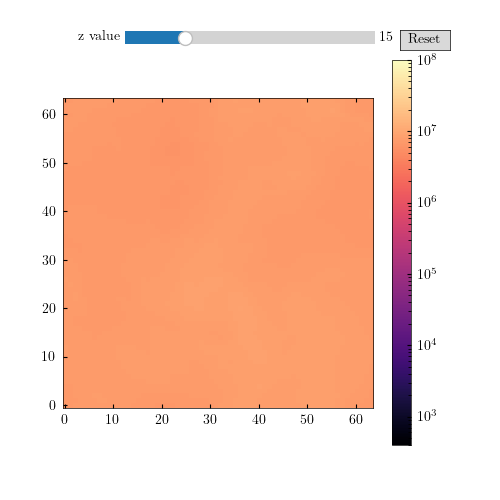

In [19]:
fname=f'{datapath}/turb/Turb.out2.00100.athdf'; verbose=True
%matplotlib widget
from matplotlib.widgets import Button, Slider

# plot temperature
z_range = [0, 63]
z_init = 15
rho = get_datamd(fname=fname, verbose=verbose, key='rho')
press = get_datamd(fname=fname, verbose=verbose, key='press')
temperature = calc_T(press, rho)
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
img = plt.imshow(temperature[z_init], interpolation='none', norm='log', vmin=400, vmax=100000000)
# plt.title('Density')
plt.colorbar()

plt.ioff()

# Make a horizontal slider to control the z slice
ax_slider = fig.add_axes([0.25, 0.90, 0.5, 0.05])
redshift_slider = Slider(
    ax=ax_slider,
    label=r'z value',
    valmin=z_range[0],
    valmax=z_range[1],
    valinit=z_init,
    valstep=1.
)

# The function to be called anytime a slider's value changes
def update(z):
    # update to redshift
    img.set_data(temperature[int(z)])
    fig.canvas.draw_idle()
redshift_slider.on_changed(update)  # register the update function with each slider

# Create a button to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.9, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')
def reset(event):
    redshift_slider.reset()
button.on_clicked(reset)
plt.show()
%matplotlib inline
plotting_def()

#### Cloud introduced

['Coordinates', 'DatasetNames', 'MaxLevel', 'MeshBlockSize', 'NumCycles', 'NumMeshBlocks', 'NumVariables', 'RootGridSize', 'RootGridX1', 'RootGridX2', 'RootGridX3', 'Time', 'VariableNames', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3']
['Coordinates', 'DatasetNames', 'MaxLevel', 'MeshBlockSize', 'NumCycles', 'NumMeshBlocks', 'NumVariables', 'RootGridSize', 'RootGridX1', 'RootGridX2', 'RootGridX3', 'Time', 'VariableNames', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3']


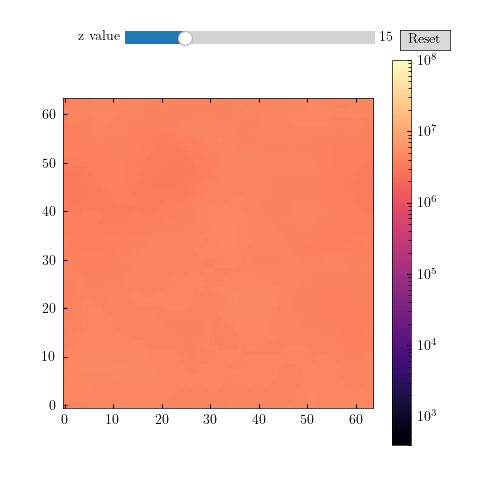

In [20]:
fname=f'{datapath}/cloud/Turb.out2.00101.athdf'; verbose=True
%matplotlib widget
from matplotlib.widgets import Button, Slider

# plot temperature
z_range = [0, 63]
z_init = 15
rho = get_datamd(fname=fname, verbose=verbose, key='rho')
press = get_datamd(fname=fname, verbose=verbose, key='press')
temperature = calc_T(press, rho)
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
img = plt.imshow(temperature[z_init], interpolation='none', norm='log', vmin=400, vmax=100000000)
# plt.title('Density')
plt.colorbar()

plt.ioff()

# Make a horizontal slider to control the z slice
ax_slider = fig.add_axes([0.25, 0.90, 0.5, 0.05])
redshift_slider = Slider(
    ax=ax_slider,
    label=r'z value',
    valmin=z_range[0],
    valmax=z_range[1],
    valinit=z_init,
    valstep=1.
)

# The function to be called anytime a slider's value changes
def update(z):
    # update to redshift
    img.set_data(temperature[int(z)])
    fig.canvas.draw_idle()
redshift_slider.on_changed(update)  # register the update function with each slider

# Create a button to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.9, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')
def reset(event):
    redshift_slider.reset()
button.on_clicked(reset)
plt.show()
%matplotlib inline
plotting_def()

['Coordinates', 'DatasetNames', 'MaxLevel', 'MeshBlockSize', 'NumCycles', 'NumMeshBlocks', 'NumVariables', 'RootGridSize', 'RootGridX1', 'RootGridX2', 'RootGridX3', 'Time', 'VariableNames', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3']


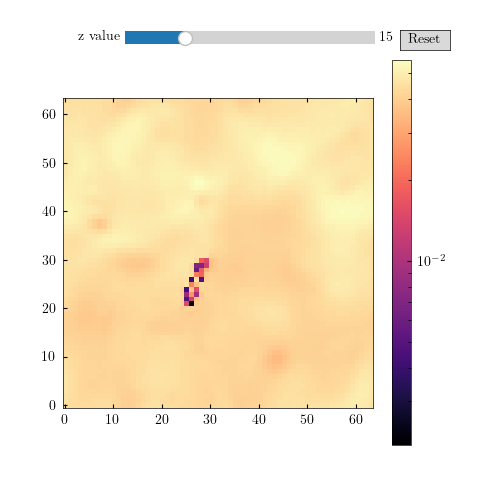

In [21]:
"""Pressure distribution of the cloud"""

fname=f'{datapath}/cloud/Turb.out2.00120.athdf'; verbose=True
%matplotlib widget
from matplotlib.widgets import Button, Slider

# plot temperature
z_range = [0, 63]
z_init = 15
press = get_datamd(fname=fname, verbose=verbose, key='press')
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
img = plt.imshow(press[z_init], interpolation='none', norm='log')
# plt.title('Density')
plt.colorbar()

plt.ioff()

# Make a horizontal slider to control the z slice
ax_slider = fig.add_axes([0.25, 0.90, 0.5, 0.05])
redshift_slider = Slider(
    ax=ax_slider,
    label=r'z value',
    valmin=z_range[0],
    valmax=z_range[1],
    valinit=z_init,
    valstep=1.
)

# The function to be called anytime a slider's value changes
def update(z):
    # update to redshift
    img.set_data(press[int(z)])
    fig.canvas.draw_idle()
redshift_slider.on_changed(update)  # register the update function with each slider

# Create a button to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.9, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')
def reset(event):
    redshift_slider.reset()
button.on_clicked(reset)
plt.show()
%matplotlib inline
plotting_def()

['Coordinates', 'DatasetNames', 'MaxLevel', 'MeshBlockSize', 'NumCycles', 'NumMeshBlocks', 'NumVariables', 'RootGridSize', 'RootGridX1', 'RootGridX2', 'RootGridX3', 'Time', 'VariableNames', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3']


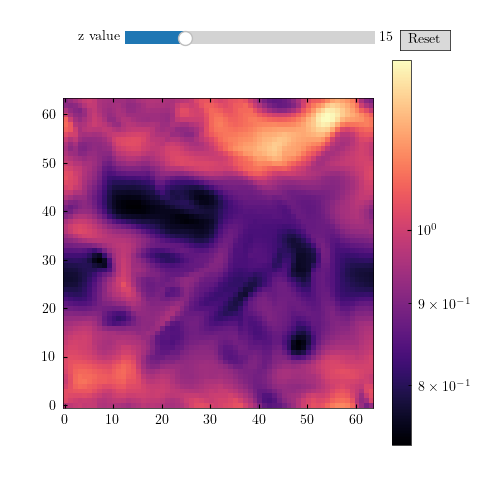

In [22]:
"""DENSITY distribution of the cloud"""

fname=f'{datapath}/cloud/Turb.out2.00110.athdf'; verbose=True
%matplotlib widget
from matplotlib.widgets import Button, Slider

# plot temperature
z_range = [0, 63]
z_init = 15
rho = get_datamd(fname=fname, verbose=verbose, key='rho')
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
img = plt.imshow(rho[z_init], interpolation='none', norm='log')
# plt.title('Density')
plt.colorbar()

plt.ioff()

# Make a horizontal slider to control the z slice
ax_slider = fig.add_axes([0.25, 0.90, 0.5, 0.05])
redshift_slider = Slider(
    ax=ax_slider,
    label=r'z value',
    valmin=z_range[0],
    valmax=z_range[1],
    valinit=z_init,
    valstep=1.
)

# The function to be called anytime a slider's value changes
def update(z):
    # update to redshift
    img.set_data(rho[int(z)])
    fig.canvas.draw_idle()
redshift_slider.on_changed(update)  # register the update function with each slider

# Create a button to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.9, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')
def reset(event):
    redshift_slider.reset()
button.on_clicked(reset)
plt.show()
%matplotlib inline
plotting_def()

#### End

In [23]:
end_epoch = 400

['Coordinates', 'DatasetNames', 'MaxLevel', 'MeshBlockSize', 'NumCycles', 'NumMeshBlocks', 'NumVariables', 'RootGridSize', 'RootGridX1', 'RootGridX2', 'RootGridX3', 'Time', 'VariableNames', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3']
['Coordinates', 'DatasetNames', 'MaxLevel', 'MeshBlockSize', 'NumCycles', 'NumMeshBlocks', 'NumVariables', 'RootGridSize', 'RootGridX1', 'RootGridX2', 'RootGridX3', 'Time', 'VariableNames', 'x1f', 'x1v', 'x2f', 'x2v', 'x3f', 'x3v', 'rho', 'press', 'vel1', 'vel2', 'vel3']


0

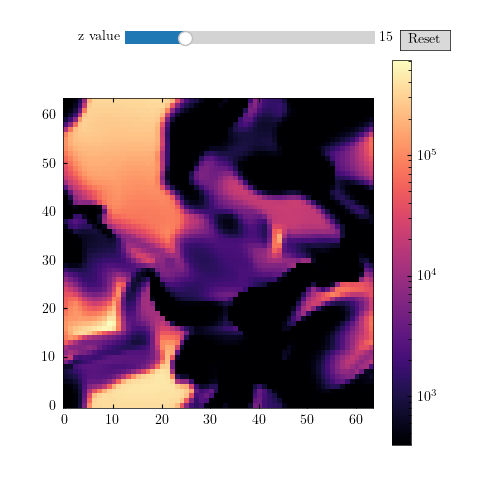

In [24]:
"""Temperature at the end"""
fname=f'{datapath}/cloud/Turb.out2.00{end_epoch}.athdf'; verbose=True
%matplotlib widget
from matplotlib.widgets import Button, Slider

# plot temperature
z_range = [0, 63]
z_init = 15
rho = get_datamd(fname=fname, verbose=verbose, key='rho')
press = get_datamd(fname=fname, verbose=verbose, key='press')
temperature = calc_T(press, rho)
fig, ax = plt.subplots(figsize=(5, 5), dpi=100)

"""Pressure plot"""
img = plt.imshow(temperature[z_init], interpolation='none', norm='log')#, vmin=400, vmax=100000000)
# plt.title('Density')
plt.colorbar()

plt.ioff()

# Make a horizontal slider to control the z slice
ax_slider = fig.add_axes([0.25, 0.90, 0.5, 0.05])
redshift_slider = Slider(
    ax=ax_slider,
    label=r'z value',
    valmin=z_range[0],
    valmax=z_range[1],
    valinit=z_init,
    valstep=1.
)

# The function to be called anytime a slider's value changes
def update(z):
    # update to redshift
    img.set_data(temperature[int(z)])
    fig.canvas.draw_idle()
redshift_slider.on_changed(update)  # register the update function with each slider

# Create a button to reset the sliders to initial values.
resetax = fig.add_axes([0.8, 0.9, 0.1, 0.04])
button = Button(resetax, 'Reset', hovercolor='0.975')
def reset(event):
    redshift_slider.reset()
button.on_clicked(reset)

### Hist

In [156]:
"""Define constants for the run"""

T_scale = 4e6
cloud_chi = 10000;
T_cold = T_scale / cloud_chi

T_cut = 2e6

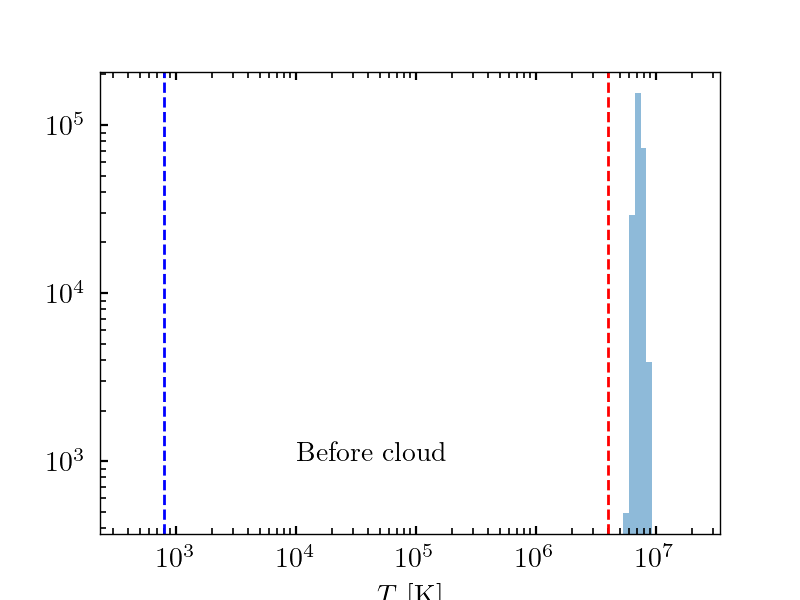

In [26]:
fname=f'{datapath}/turb/Turb.out2.00100.athdf'
# plot density
z_range = [0, 63]
z_init = 15
rho = get_datamd(fname=fname, verbose=False, key='rho')
press = get_datamd(fname=fname, verbose=False, key='press')
temperature = calc_T(press, rho)

plt.subplots(figsize=(4, 3))
plt.hist(temperature.flatten(), alpha=0.5,
         bins=np.logspace(np.log10(400), np.log10(2e7), 100))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$T$ [K]')
plt.axvline(T_scale, color='red', lw=1, ls='--')
plt.axvline(T_cold, color='blue', lw=1, ls='--')
plt.text(1e4, 1000, 'Before cloud')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


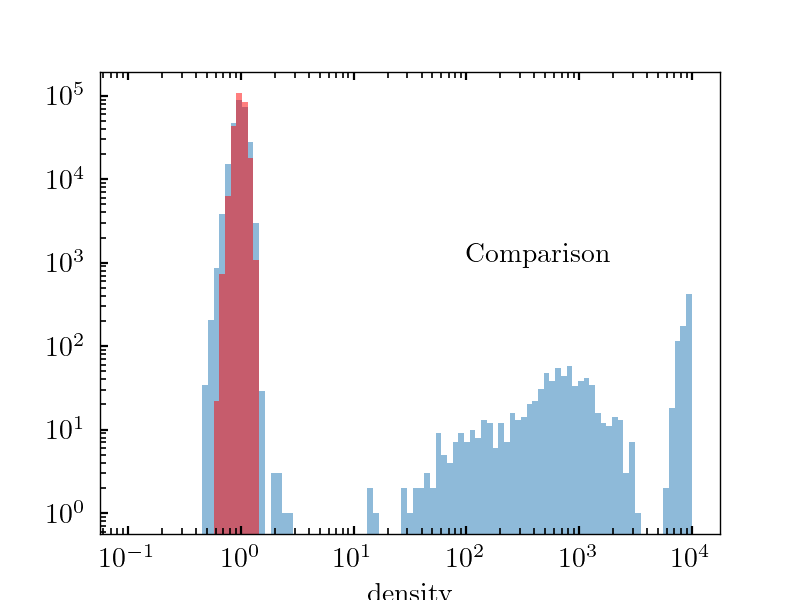

In [27]:
fname=f'{datapath}/cloud/Turb.out2.00101.athdf'; verbose=True
# plot density
rho = get_datamd(fname=fname, verbose=False, key='rho')
press = get_datamd(fname=fname, verbose=False, key='press')
temperature = calc_T(press, rho)

plt.subplots(figsize=(4, 3))
plt.hist(rho.flatten(), alpha=0.5,
         bins=np.logspace(-1, 4, 100))

fname=f'{datapath}/turb/Turb.out2.00100.athdf'; verbose=True
# plot density
rho = get_datamd(fname=fname, verbose=False, key='rho')
press = get_datamd(fname=fname, verbose=False, key='press')
temperature = calc_T(press, rho)

# plt.subplots(figsize=(4, 3))
plt.hist(rho.flatten(), alpha=0.5,
         bins=np.logspace(-1, 4, 100), color='red')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('density')
# plt.axvline(T_scale, color='red', lw=1, ls='--', label='hot')
# plt.axvline(T_cut, color='orange', lw=1, ls='-.', label='cooling lim')
# plt.axvline(4e4, color='green', lw=1, ls='--', label='warm')
# plt.axvline(T_cold, color='blue', lw=1, ls='--', label='cold')
plt.text(1e2, 1000, 'Comparison')
plt.legend()
plt.show()

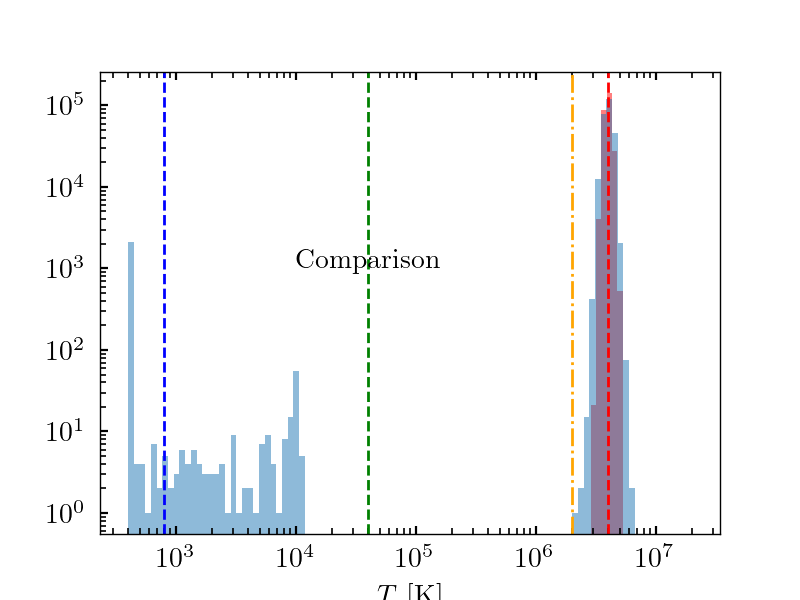

In [28]:
fname=f'{datapath}/turb/Turb.out2.00100.athdf'
# plot density
z_range = [0, 63]
z_init = 15
rho = get_datamd(fname=fname, verbose=False, key='rho')
press = get_datamd(fname=fname, verbose=False, key='press')
temperature = calc_T(press, rho)

plt.subplots(figsize=(4, 3))
plt.hist(temperature.flatten() * T_scale / np.mean(temperature), alpha=0.5,
         bins=np.logspace(np.log10(800), np.log10(2e7), 100), color='red')


fname=f'{datapath}/cloud/Turb.out2.00101.athdf'; verbose=True
# plot density
rho = get_datamd(fname=fname, verbose=False, key='rho')
press = get_datamd(fname=fname, verbose=False, key='press')
temperature = calc_T(press, rho)

plt.hist(temperature.flatten(), alpha=0.5,
         bins=np.logspace(np.log10(400), np.log10(2e7), 100))

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$T$ [K]')
plt.axvline(T_scale, color='red', lw=1, ls='--', label='hot')
plt.axvline(T_cut, color='orange', lw=1, ls='-.', label='cooling lim')
plt.axvline(4e4, color='green', lw=1, ls='--', label='warm')
plt.axvline(T_cold, color='blue', lw=1, ls='--', label='cold')
plt.text(1e4, 1000, 'Comparison')
plt.show()

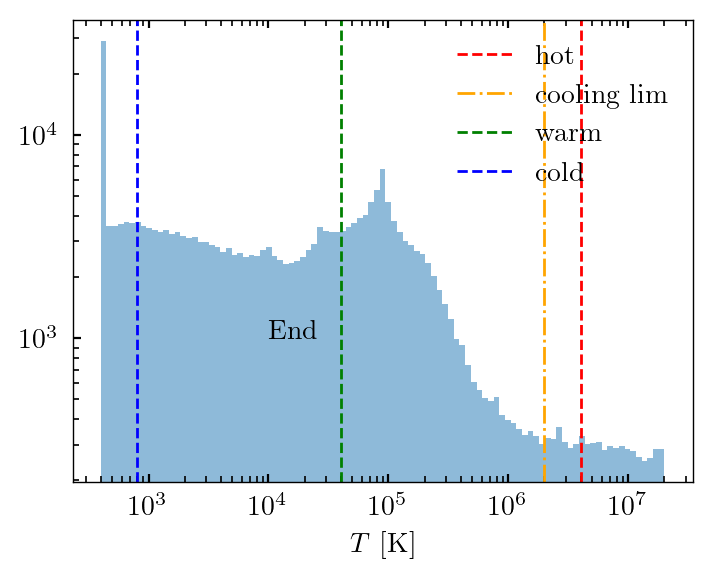

In [72]:
fname=f'{datapath}/cloud/Turb.out2.00{end_epoch}.athdf'; verbose=True
# plot density
rho = get_datamd(fname=fname, verbose=False, key='rho')
press = get_datamd(fname=fname, verbose=False, key='press')
temperature = calc_T(press, rho)

plt.subplots(figsize=(4, 3))
plt.hist(temperature.flatten(), alpha=0.5,
         bins=np.logspace(np.log10(400), np.log10(2e7), 100))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$T$ [K]')
plt.axvline(T_scale, color='red', lw=1, ls='--', label='hot')
plt.axvline(T_cut, color='orange', lw=1, ls='-.', label='cooling lim')
plt.axvline(4e4, color='green', lw=1, ls='--', label='warm')
plt.axvline(T_cold, color='blue', lw=1, ls='--', label='cold')
plt.text(1e4, 1000, 'End')
plt.legend()
plt.show()

## 3d visualizations

### Evolution

In [30]:
T_cold

800.0

In [ ]:
import plotly.graph_objects as go
import plotly.express as px

# grab the temperature
fname=f'{datapath}/cloud/Turb.out2.00101.athdf'; verbose=False
# plot density
z_range = [0, 63]
z_init = 15
rho = get_datamd(fname=fname, verbose=verbose, key='rho')
press = get_datamd(fname=fname, verbose=verbose, key='press')
temperature = calc_T(press, rho)

# visualize
X, Y, Z = np.mgrid[-32:31:64j, -32:31:64j, -32:31:64j]
fig = go.Figure(data=go.Volume(
    x=X.flatten(),
    y=Y.flatten(),
    z=Z.flatten(),
    value=np.log10(temperature.flatten()),
    opacity=0.1,  # needs to be small to see through all surfaces
    surface_count=1,  # Display only one surface
    isomin=np.log10(T_cold),  # Minimum temperature for isosurface
    isomax=np.log10(T_cold),  # Maximum temperature for isosurface
    colorscale=[[0.0, "rgb(0,0,0)"], [1.0, "rgb(0,0,0)"]],#'RdBu_r',
    colorbar=dict(title='Temperature'),
    # cmin=1,  # Set the minimum color scale value
    # cmax=7  # Set the maximum color scale value (adjust as needed)
), layout={'height': 800})
# fig.show()

### Animation 3d

In [32]:
# import plotly.graph_objects as go
# import numpy as np

# # construct a list of files
# file_list = []
# for fnum in np.arange(101, end_epoch+1, 1).astype(int):
#     fname = f'{datapath}/cloud/Turb.out2.00{fnum:.0f}.athdf'
#     file_list.append(fname)

# # Generate grid for plotting
# X, Y, Z = np.mgrid[-32:31:64j, -32:31:64j, -32:31:64j]

# # Create initial figure
# fig = go.Figure(layout={'height': 800})

# # Initialize frames list
# frames = []

# # Loop over filenames to create frames
# for fname in file_list:
#     rho = get_datamd(fname=fname, verbose=False, key='rho')
#     press = get_datamd(fname=fname, verbose=False, key='press')
#     temperature = calc_T(press, rho)
    
#     frames.append(go.Frame(
#         data=[go.Volume(
#             x=X.flatten(),
#             y=Y.flatten(),
#             z=Z.flatten(),
#             value=np.log10(temperature.flatten()),
#             opacity=0.1,  # needs to be small to see through all surfaces
#             surface_count=1,  # Display only one surface
#             isomin=np.log10(T_cold),  # Minimum temperature for isosurface
#             isomax=np.log10(T_cold),  # Maximum temperature for isosurface
#             colorscale=[[0.0, "rgb(0,0,0)"], [1.0, "rgb(0,0,0)"]],#'RdBu_r',
#             colorbar=dict(title='Temperature'),
#             cmin=2,  # Set the minimum color scale value
#             cmax=7  # Set the maximum color scale value (adjust as needed)
#         )],
#         name=fname
#     ))

# # Add initial data
# rho = get_datamd(fname=file_list[0], verbose=False, key='rho')
# press = get_datamd(fname=file_list[0], verbose=False, key='press')
# temperature = calc_T(press, rho)

# fig.add_trace(go.Volume(
#     x=X.flatten(),
#     y=Y.flatten(),
#     z=Z.flatten(),
#     value=np.log10(temperature.flatten()),
#     opacity=0.1,  # needs to be small to see through all surfaces
#     surface_count=1,  # Display only one surface
#     isomin=np.log10(T_cold),  # Minimum temperature for isosurface
#     isomax=np.log10(T_cold),  # Maximum temperature for isosurface
#     colorscale=[[0.0, "rgb(0,0,0)"], [1.0, "rgb(0,0,0)"]],#'RdBu_r',
#     colorbar=dict(title='Temperature')
# ))

# # Add frames to figure
# fig.frames = frames

# # Add animation settings
# fig.update_layout(
#     updatemenus=[{
#         'buttons': [
#             {
#                 'args': [None, {'frame': {'duration': 500, 'redraw': True}, 'fromcurrent': True}],
#                 'label': 'Play',
#                 'method': 'animate'
#             },
#             {
#                 'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
#                 'label': 'Pause',
#                 'method': 'animate'
#             }
#         ],
#         'direction': 'left',
#         'pad': {'r': 10, 't': 87},
#         'showactive': False,
#         'type': 'buttons',
#         'x': 0.1,
#         'xanchor': 'right',
#         'y': 0,
#         'yanchor': 'top'
#     }]
# )

# fig.update_layout(
#     sliders=[{
#         'active': 0,
#         'yanchor': 'top',
#         'xanchor': 'left',
#         'currentvalue': {
#             'font': {'size': 20},
#             'prefix': 'Frame:',
#             'visible': True,
#             'xanchor': 'right'
#         },
#         'transition': {'duration': 30},
#         'pad': {'b': 10, 't': 50},
#         'len': 0.9,
#         'x': 0.1,
#         'y': 0,
#         'steps': [{
#             'args': [[fname], {'frame': {'duration': 30, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 30}}],
#             'label': fname,
#             'method': 'animate'
#         } for fname in file_list]
#     }]
# )

# f = open('figs/temperature_animation_fast.html', "w")
# f.close()
# with open('figs/temperature_animation_fast.html', 'a') as f:
#     f.write(fig.to_html(full_html=False, include_plotlyjs='cdn'))
# f.close()

## Other quantities

In [34]:
# # def visualize_3d(fname=f'{datapath}/turb_240528/Turb.out3.00004.athdf', verbose=True, key='dens'):
# fname=f'{datapath}/turb_240529/cloud/Turb.out2.00{end_epoch}.athdf'; verbose=True; key = 'rho'
# %matplotlib widget
# from matplotlib.widgets import Button, Slider

# # plot density
# z_range = [0, 63]
# z_init = 10
# data = get_datamd(fname=fname, verbose=verbose, key=key)
# fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
# img = plt.imshow(data[z_init], interpolation='none', norm='log')
# # plt.title('Density')
# plt.colorbar()

# plt.ioff()

# # Make a horizontal slider to control the z slice
# ax_slider = fig.add_axes([0.25, 0.90, 0.5, 0.05])
# redshift_slider = Slider(
#     ax=ax_slider,
#     label=r'z value',
#     valmin=z_range[0],
#     valmax=z_range[1],
#     valinit=z_init,
#     valstep=1.
# )

# # The function to be called anytime a slider's value changes
# def update(z):
#     # update to redshift
#     img.set_data(data[int(z)])
#     fig.canvas.draw_idle()
# redshift_slider.on_changed(update)  # register the update function with each slider

# # Create a button to reset the sliders to initial values.
# resetax = fig.add_axes([0.8, 0.9, 0.1, 0.04])
# button = Button(resetax, 'Reset', hovercolor='0.975')
# def reset(event):
#     redshift_slider.reset()
# button.on_clicked(reset)
plt.show()
%matplotlib inline
plotting_def()

# Cold gas evolution

## Consistency check

In [90]:
import plotly.graph_objects as go
import numpy as np

"""construct a list of files"""
file_list = []
for fnum in np.arange(101, end_epoch+1, 1).astype(int):
    fname = f'{datapath}/cloud/Turb.out2.00{fnum:.0f}.athdf'
    file_list.append(fname)

"""array of hot / cold gas mass"""
mass_cg = []
mass_hg = []
time_athdf = []

# calculate grid volume
grid_size = 1 / 64 ** 3

for fname in file_list:
    t = get_datamd(fname=fname, verbose=False, key='Time')
    rho = get_datamd(fname=fname, verbose=False, key='rho').flatten()
    press = get_datamd(fname=fname, verbose=False, key='press').flatten()
    temperature = calc_T(press, rho)

    # select cold and hot gas densities
    cgm = np.sum(rho[temperature <= T_cold]) * grid_size
    hgm = np.sum(rho[temperature >= T_cut]) * grid_size

    # append
    time_athdf.append(t)
    mass_cg.append(cgm); mass_hg.append(hgm)

# the time for athena
mass_cg = np.array(mass_cg)
mass_hg = np.array(mass_hg)

In [91]:
len(mass_cg)

300

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


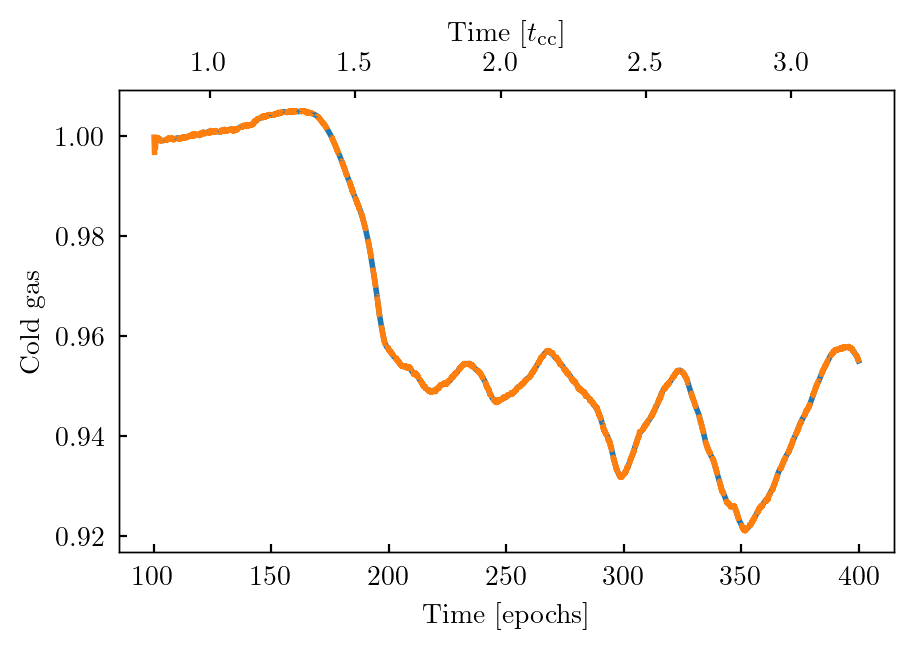

In [105]:
"""
Compare with hist file
"""

# grab the hst file data
fname = f'{datapath}/turb/Turb.hst'
with open(fname, 'r') as file: keys_raw = file.readlines()[1]
keys = [a.split('=')[1] for a in keys_raw.split()[1:]]
fname = f'{datapath}/cloud/Turb.hst'
data = np.loadtxt(fname).T
dataf = {keys[i]: data[i] for i in range(len(keys))}

v_turb_mean = .17
t_cc = (5000 ** (1/2) * .125 / v_turb_mean)

# plot athdf version
fig, ax1 = plt.subplots(figsize=(5,3))

plt.plot(np.array(time_athdf)/0.42, mass_cg / dataf['cold_gas'][1], ls='-', label='calculated')
# plot hst version
ax1.plot(dataf['time']/0.42, dataf['cold_gas'] / dataf['cold_gas'][1], ls='--', label='hst')

# ax1.set_yscale('log')
ax1.set_ylabel('Cold gas %%')
ax1.set_xlabel('Time [epochs]')

ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(t_cc / 0.42 * np.linspace(1, 3, 5))
ax2.set_xticklabels(np.linspace(1, 3, 5))
ax2.set_xlabel(r"Time [$t_{\rm cc}$]")

plt.legend()
plt.show()

## Animation stacked

In [54]:
import matplotlib.animation as animation

# construct a list of files
file_list = []
for fnum in np.arange(101, end_epoch+1, 1).astype(int):
    fname = f'{datapath}/cloud/Turb.out2.00{fnum:.0f}.athdf'
    file_list.append(fname)

# Initialize frames list
frames_T = []
frames_rhosq = []

# Loop over filenames to create frames
for fname in file_list:
    rho = get_datamd(fname=fname, verbose=False, key='rho')
    press = get_datamd(fname=fname, verbose=False, key='press')
    temperature = calc_T(press, rho)

    # flatten density sq
    rhosq2d = np.sum(np.square(rho), axis=0)
    frames_rhosq.append(rhosq2d)
    
    # flatten temperature
    temperature2d = np.sum(temperature, axis=0)
    frames_T.append(temperature2d)

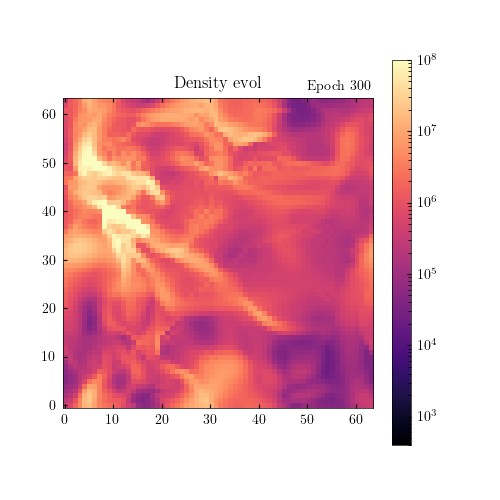

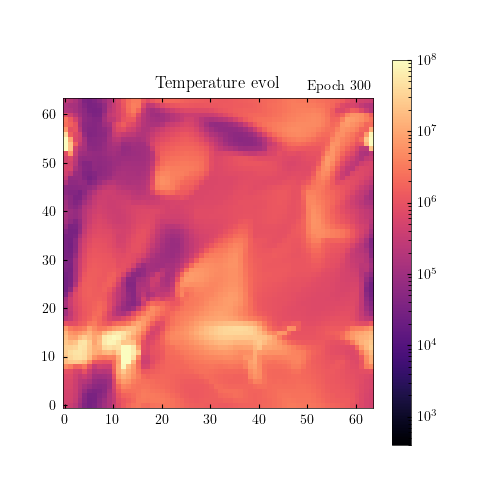

In [70]:
def animate_prop(frames_prop=frames_T, prop_name='temperature'):
    %matplotlib widget
    from matplotlib.colors import LogNorm
    fig, ax = plt.subplots(figsize=(5, 5), dpi=100)
    img = plt.imshow(frames_prop[0], interpolation='none', norm=LogNorm(vmin=400, vmax=100000000))
    epoch_text = plt.text(50, 65, f'Epoch {100}')
    plt.title(f'{prop_name} evol')
    plt.colorbar()
    plt.ioff()
    
    # Update the frame
    def update(iframe):
        img.set_data(frames_prop[iframe])
        epoch_text.set_text(f'Epoch {101+iframe}')
        return [img, epoch_text]
    
    ani = animation.FuncAnimation(fig=fig, func=update, frames=np.arange(200), interval=20, blit=True)
    ani.save(filename=f"figs/{prop_name}_flatten.gif".lower(), writer="pillow")
    plt.show()
    %matplotlib inline

animate_prop(frames_rhosq, prop_name='Density')
animate_prop(frames_T, prop_name='Temperature')

# Parameter space

# Cold gas mass fraction

In [108]:
"""
Parameter plot with initial cold gas mass
"""

mass_cg_ini = mass_cg[0]
mass_cg_fin = mass_cg[-1]

log_mass_frac = [np.log10(mass_cg_fin / mass_cg_ini)]
log_mass_frac

[-0.01964872385647867]

## Load scripts

In [74]:
# Import the cooling function from Hitesh's scripts
import sys
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena/cooling_scripts'))
import cooling_fn as cf
sys.path.append(os.path.abspath('/freya/ptmp/mpa/wuze/athena/helper_scripts'))
import v_turb as vt

In [75]:
# hot gas density
rho_hot = 1 # in code unit

T_arr = np.logspace(2, 8, 100)  # in kelvin
rho_arr = rho_hot * T_scale / T_arr

"""
Cooling & Heating functions
"""
Gamma_n_arr = 1e-26 / rho_arr
Lambda_arr = np.vectorize(cf.Lam_fn_powerlaw)(T_arr, Zsol=1.0, Lambda_fac=1.0)

"""
Cooling & Heating rates
"""
heating_rate = 1e-26 * rho_arr

Lambda_arr = np.vectorize(cf.Lam_fn_powerlaw)(T_arr, Zsol=1.0, Lambda_fac=1.0)
cooling_rate = Lambda_arr * rho_arr**2


"""
Timescale
"""
tcool_arr = np.vectorize(cf.tcool_calc)(
    rho_arr, T_arr, Zsol=1.0, Lambda_fac=1.0, fit_type="max"
)

### Cooling function

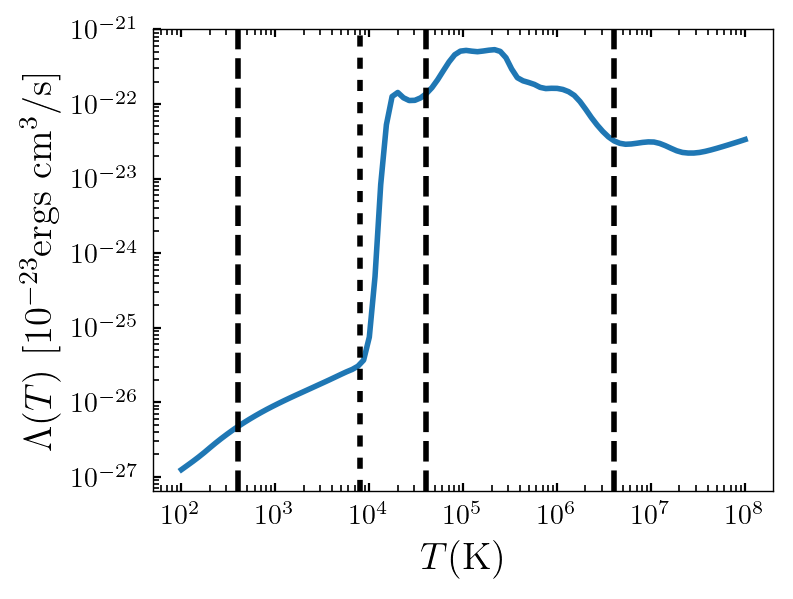

In [76]:
plt.figure(figsize=(4, 3))
plt.plot(T_arr, Lambda_arr, label=r"$\Lambda(T)$")

plt.ylabel(r"$\Lambda(T)$  $[10^{-23}  \mathrm{ergs ~ cm}^3/\mathrm{s}]$", fontsize=14)
plt.xlabel(r"$T$(K)", fontsize=14)

plt.yscale("log")
plt.xscale("log")

plt.axvline(x=4e2, color="k", linestyle="--")
plt.axvline(x=4e4, color="k", linestyle="--")
plt.axvline(x=4e6, color="k", linestyle="--")
plt.axvline(x=8e3, color="k", linestyle=":")
plt.show()

### Cooling rate & timescale

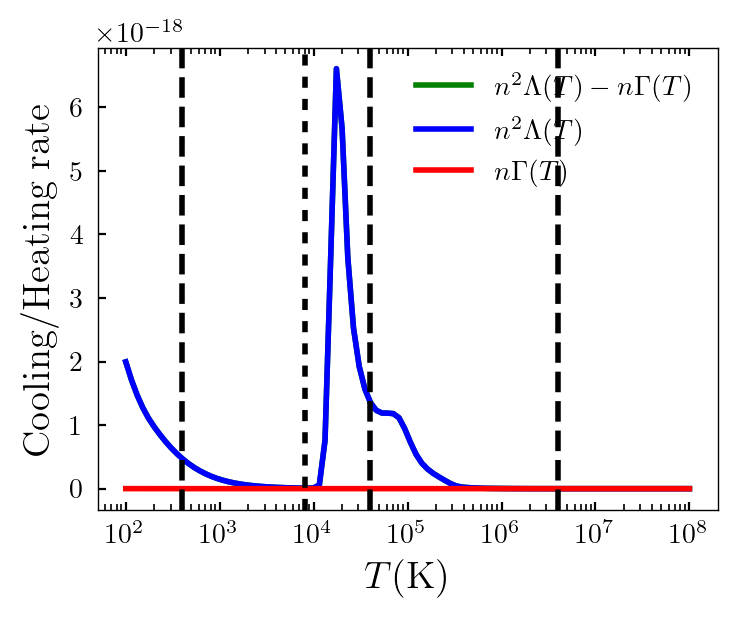

In [79]:
plt.figure(figsize=(4, 3))
plt.plot(T_arr, cooling_rate - heating_rate, color='green', label=r"$n^2\Lambda(T) - n\Gamma(T) $")
plt.plot(T_arr, cooling_rate, color='blue', label=r"$n^2\Lambda(T)$")
plt.plot(T_arr, heating_rate, color='red', label=r"$n\Gamma(T)$")

plt.ylabel(r"Cooling/Heating rate", fontsize=14)
plt.xlabel(r"$T$(K)", fontsize=14)

# plt.yscale("log")
plt.xscale("log")

# plt.ylim(0.0, 5e-15)

plt.legend()

plt.axvline(x=4e2, color="k", linestyle="--")
plt.axvline(x=4e4, color="k", linestyle="--")
plt.axvline(x=4e6, color="k", linestyle="--")
plt.axvline(x=8e3, color="k", linestyle=":")
plt.show()

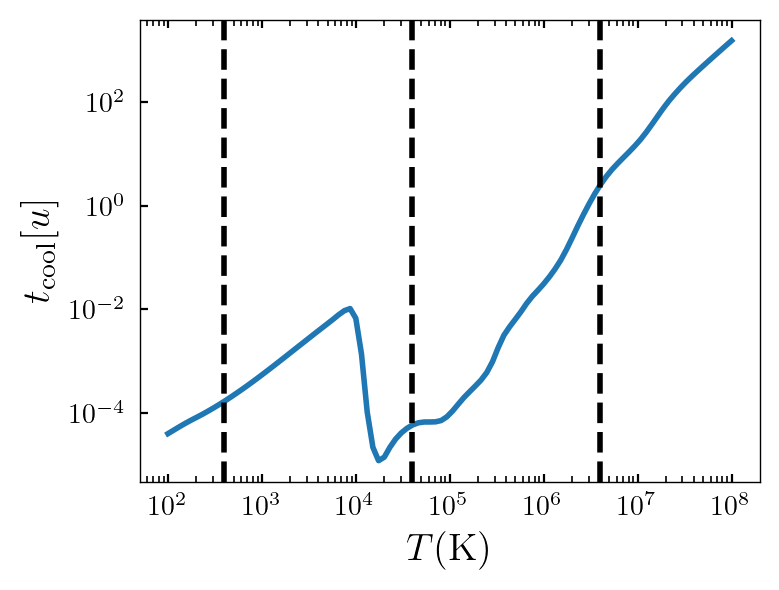

In [80]:
plt.figure(figsize=(4, 3))
plt.plot(T_arr, tcool_arr, label=r"$\Lambda(T)$")

# define cooling time
t_cool_func = lambda T : np.interp(T, T_arr, tcool_arr)

plt.ylabel(r"$t_{\rm cool} [u]$", fontsize=14)
plt.xlabel(r"$T$(K)", fontsize=14)

plt.yscale("log")
plt.xscale("log")

plt.axvline(x=4e2, color="k", linestyle="--")
plt.axvline(x=4e4, color="k", linestyle="--")
plt.axvline(x=4e6, color="k", linestyle="--")
plt.axvline(x=8e3, color="k", linestyle="")
plt.show()

## R_cl / l_shatter

## Calculate shatter length scale

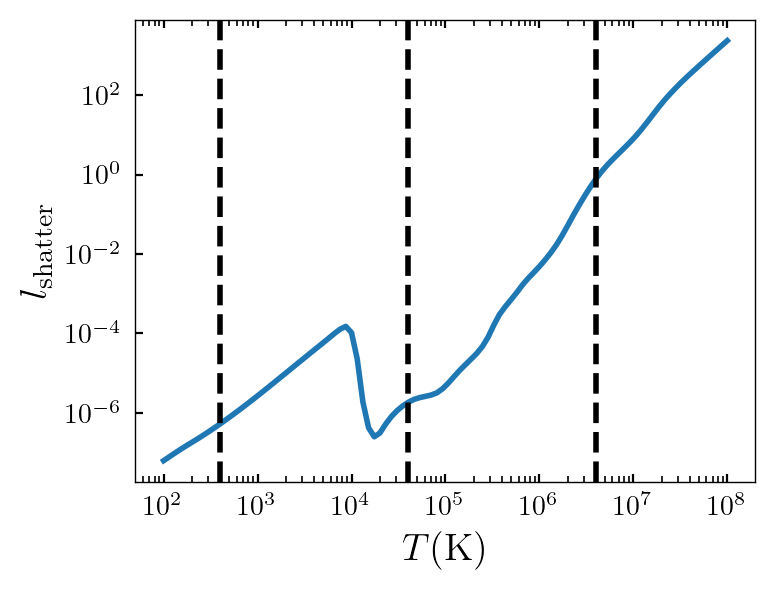

In [83]:
plt.figure(figsize=(4, 3))

# shatter length scale
l_shatter = t_cool_func(T_arr) * calc_cs(T_arr)
plt.plot(T_arr, l_shatter)

plt.ylabel(r"$l_{\rm shatter}$", fontsize=14)
plt.xlabel(r"$T$(K)", fontsize=14)

plt.yscale("log")
plt.xscale("log")

plt.axvline(x=4e2, color="k", linestyle="--")
plt.axvline(x=4e4, color="k", linestyle="--")
plt.axvline(x=4e6, color="k", linestyle="--")
plt.axvline(x=8e3, color="k", linestyle="")
plt.show()

In [170]:
r_cl = 0.125

## Cooling timescales at T

In [185]:
t_cool_func = lambda T : cf.tcool_calc(rho_hot * T_scale / T, T, Zsol=1.0, Lambda_fac=1.0, fit_type="max")

In [181]:
T_cold = 4e4

In [182]:
# calculate geometric mean T_mix
print(f'T_cold = {T_cold}')
print(f'T_hot = {T_scale:.2e}')
T_mix = np.sqrt(T_cold * T_scale)
print(f'T_mix = {T_mix:.2e}')

t_cool_mix = t_cool_func(T_mix)
t_cool_cold = t_cool_func(T_cold)
print(f't_cool,mix = {t_cool_mix:.2e}')
print(f't_cool,cold = {t_cool_cold:.2e}')


l_shatter_min = np.min(l_shatter[find_ind_l(T_arr, T_cold) : find_ind_l(T_arr, T_scale)])
vel_frac = r_cl / l_shatter_min
vel_frac

T_cold = 40000.0
T_hot = 4.00e+06
T_mix = 4.00e+05
t_cool,mix = 3.78e-03
t_cool,cold = 5.92e-05


67164.64145041384

## Plot

In [183]:
machs = [0.55]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


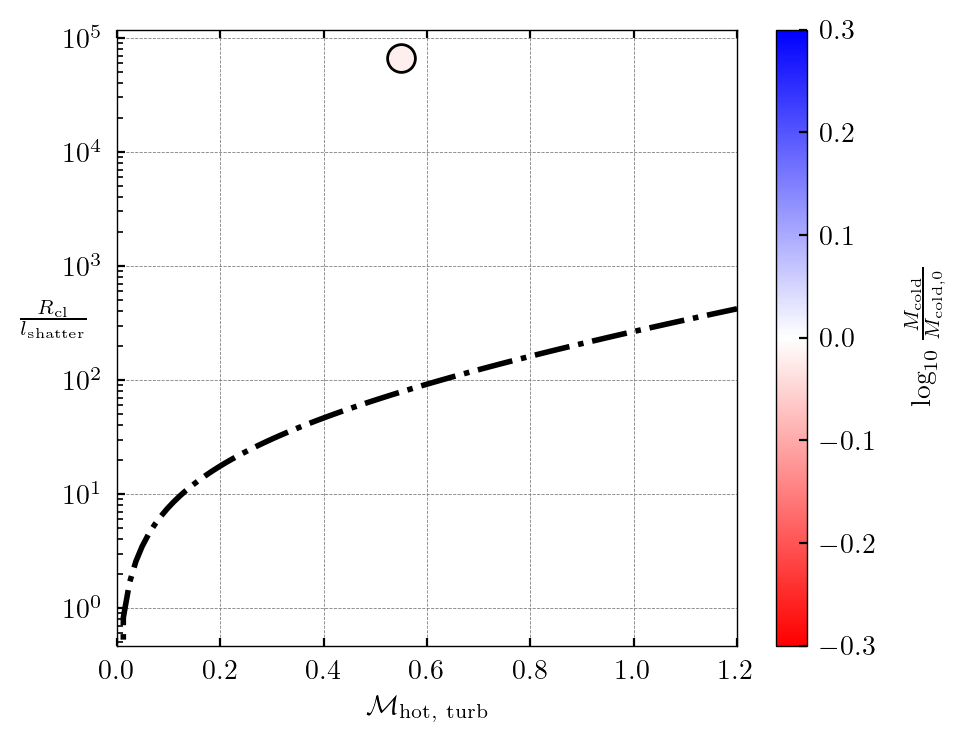

In [188]:
plt.subplots(figsize=(5,4))
cm = plt.colormaps['bwr_r']

# scatter the points
sc = plt.scatter(machs, vel_frac, marker='o',
                 c=log_mass_frac, vmin=-0.3, vmax=0.3, ec='k', cmap=cm)

# analytical line
ana_x = np.linspace(0, 1.2, 100)
ana_y = ana_x * t_cool_mix / t_cool_cold * 10. ** (0.6 * ana_x + 0.02)
plt.plot(ana_x, ana_y, ls='-.', color='k')

# axis
plt.xlim(0, 1.2)
# plt.ylim(np.power(10., -0.5), np.power(10., 3.5))
plt.yscale('log')
plt.xlabel(r'$\mathcal{M}_{\rm hot,\ turb}$')
plt.ylabel(r'$\frac{R_{\rm cl}}{l_{\rm shatter}}$', rotation=0)

# color bar
cbar = plt.colorbar(sc)
cbar.ax.set_ylabel(r'$\log_{10} \frac{M_{\rm cold}}{M_{\rm cold, 0}}$', rotation=90, labelpad=10)
plt.legend()
plt.grid()
plt.show()